<a href="https://colab.research.google.com/github/AbdelrahmanTamer11/Image-Segmentation-for-Medical-Imaging/blob/main/image_segmentation_for_medical_imaging_leukemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import glob

In [ ]:
# Function to load and preprocess data
def load_data(image_paths, label, img_size=(128, 128)):
    images, labels = [], []
    for path in image_paths:
        img = imread(path)
        img = resize(img, img_size)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)


In [ ]:
# Function to show sample model predictions
def show_predictions(model, X_val, y_val, class_names=['Non-Diseased', 'Diseased']):
    plt.figure(figsize=(10, 10))
    for i in range(5):
        rand_idx = np.random.randint(0, len(X_val))
        img = X_val[rand_idx]
        true_label = y_val[rand_idx]
        pred_label = model.predict(np.expand_dims(img, axis=0))[0][0] > 0.5

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[int(true_label)]}\nPred: {class_names[int(pred_label)]}")
        plt.axis('off')
    plt.show()



In [ ]:
# Simplified model architecture
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPool2D((2, 2)),
        Dropout(0.4),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Function to plot accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()



In [ ]:
# Main process
train_datasets_all = [
    '../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/*.bmp',
    '../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all/*.bmp',
    '../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all/*.bmp',
]

train_datasets_hem = [
    '../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp',
    '../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp',
    '../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp',
]

# Load data
X_all, y_all = load_data(glob.glob(train_datasets_all[0]), 1)  # 1 for Diseased
for dataset in train_datasets_all[1:]:
    X_temp, y_temp = load_data(glob.glob(dataset), 1)
    X_all = np.concatenate([X_all, X_temp])
    y_all = np.concatenate([y_all, y_temp])

X_hem, y_hem = load_data(glob.glob(train_datasets_hem[0]), 0)  # 0 for Non-Diseased
for dataset in train_datasets_hem[1:]:
    X_temp, y_temp = load_data(glob.glob(dataset), 0)
    X_hem = np.concatenate([X_hem, X_temp])
    y_hem = np.concatenate([y_hem, y_temp])

X, y = np.concatenate([X_all, X_hem]), np.concatenate([y_all, y_hem])
X, y = shuffle(X, y, random_state=42)



In [ ]:
# Train-validation split
X_train, X_val = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
y_train, y_val = y[:int(0.8 * len(X))], y[int(0.8 * len(X)):]



In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)
train_datagen.fit(X_train)

# Callbacks
checkpoint = ModelCheckpoint('best_weights.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Build, train, and evaluate the model
model = build_model()
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[checkpoint])



Epoch 1/50
266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6902 - loss: 0.5733
Epoch 1: val_accuracy improved from -inf to 0.78950, saving model to best_weights.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6904 - loss: 0.5731 - val_accuracy: 0.7895 - val_loss: 0.5139
Epoch 2/50
266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7730 - loss: 0.5095
Epoch 2: val_accuracy improved from 0.78950 to 0.79278, saving model to best_weights.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.7730 - loss: 0.5095 - val_accuracy: 0.7928 - val_loss: 0.5008
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7680 - loss: 0.5063
Epoch 3: val_accuracy improved from 0.79278 to 0.79325, saving model to best_weights.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - accuracy: 0.7680 - loss: 0.5063 - val_accuracy: 0.7932 - val_loss: 0.5003
Epoch 4/50
266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7584 - loss: 0.5131
Epoch 4: val_accur

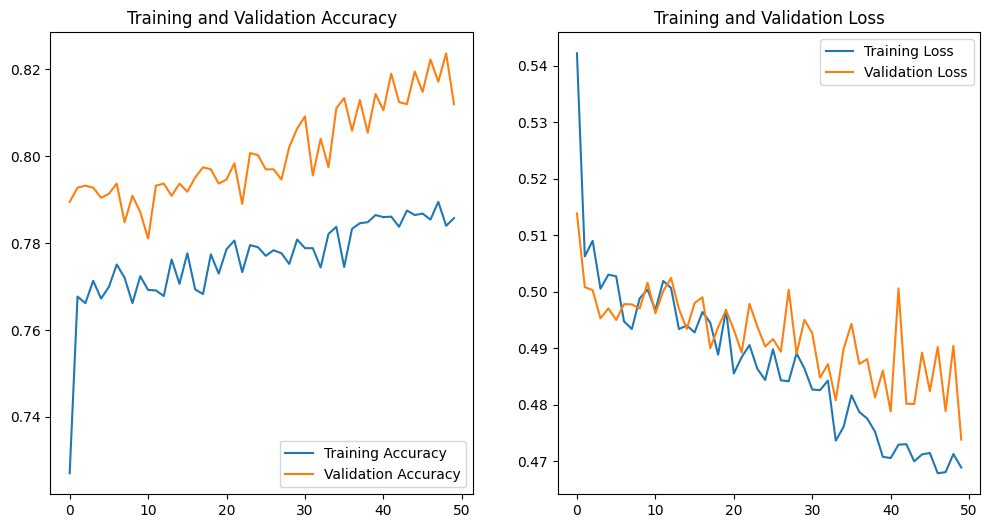

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


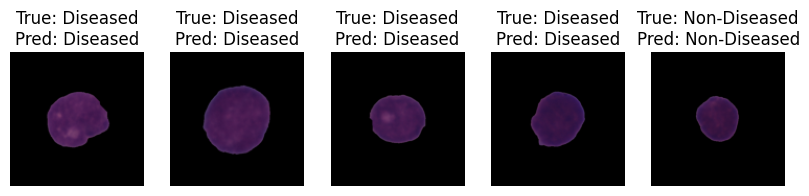

In [ ]:
# Plot accuracy and loss
plot_history(history)

# Show predictions
show_predictions(model, X_val, y_val)